# 七 优化算法

## 1 优化和深度学习

* **优化算法**主要目标是最小化目标函数，减少**训练误差**；**深度学习**主要目标是在给定有限数据量的情况下寻找合适的模型，减少**泛化误差**
* 最小化训练误差并**不能**保证我们找到最佳的参数集来最小化泛化误差。
* 深度学习优化存在许多挑战。其中最令人烦恼的是**局部最小值**、**鞍点**和**梯度消失**。
* 优化问题可能有许多局部最小值。
* 一个问题可能有很多的鞍点，因为问题通常不是凸的。
* 梯度消失可能会导致优化停滞，重参数化通常会有所帮助。对参数进行良好的初始化也可能是有益的。

### 1.1 优化目标
**优化算法**主要目标是最小化目标函数，减少**训练误差**；**深度学习**主要目标是在给定有限数据量的情况下寻找合适的模型，减少**泛化误差**

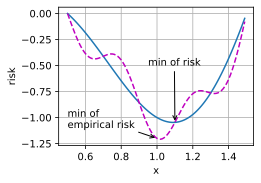

In [1]:
%matplotlib inline
import numpy as np
import torch
from mpl_toolkits import mplot3d
from d2l import torch as d2l

# 风险函数
def f(x):
    return x * torch.cos(np.pi * x)

# 经验风险函数
def g(x):
    return f(x) + 0.2 * torch.cos(5 * np.pi * x)

def annotate(text, xy, xytext):  #@save
    d2l.plt.gca().annotate(text, xy=xy, xytext=xytext,
                           arrowprops=dict(arrowstyle='->'))

x = torch.arange(0.5, 1.5, 0.01)
d2l.set_figsize((4.5, 2.5))
d2l.plot(x, [f(x), g(x)], 'x', 'risk')
annotate('min of\nempirical risk', (1.0, -1.2), (0.5, -1.1))
annotate('min of risk', (1.1, -1.05), (0.95, -0.5))

### 1.2 局部最小值

深度学习模型的目标函数通常有许多局部最优解。当优化问题的数值解接近局部最优值时，随着目标函数解的梯度接近或变为零，通过最终迭代获得的数值解可能仅使目标函数*局部*最优，而不是*全局*最优。只有一定程度的噪声可能会使参数跳出局部最小值。事实上，这是小批量随机梯度下降的有利特性之一。在这种情况下，小批量上梯度的自然变化能够将参数从局部极小值中跳出。

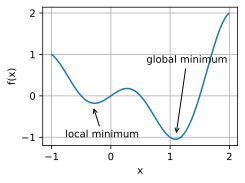

In [2]:
x = torch.arange(-1.0, 2.0, 0.01)
d2l.plot(x, [f(x), ], 'x', 'f(x)')
annotate('local minimum', (-0.3, -0.25), (-0.77, -1.0))
annotate('global minimum', (1.1, -0.95), (0.6, 0.8))

### 1.3 鞍点

除了局部最小值之外，鞍点是梯度消失的另一个原因。*鞍点*（saddle point）是指函数的所有梯度都消失但既不是全局最小值也不是局部最小值的任何位置。

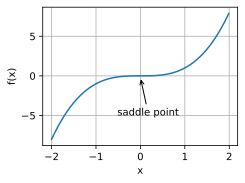

In [3]:
x = torch.arange(-2.0, 2.0, 0.01)
d2l.plot(x, [x**3], 'x', 'f(x)')
annotate('saddle point', (0, -0.2), (-0.52, -5.0))

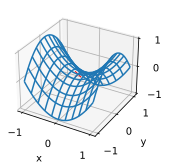

In [5]:
x, y = torch.meshgrid(
    torch.linspace(-1.0, 1.0, 101), torch.linspace(-1.0, 1.0, 101))
z = x**2 - y**2

ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 10, 'cstride': 10})
ax.plot([0], [0], [0], 'rx')
ticks = [-1, 0, 1]
d2l.plt.xticks(ticks)
d2l.plt.yticks(ticks)
ax.set_zticks(ticks)
d2l.plt.xlabel('x')
d2l.plt.ylabel('y');

### 1.4 梯度消失

梯度消失可能会导致优化停滞，重参数化通常会有所帮助。对参数进行良好的初始化也可能是有益的

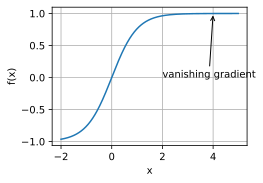

In [6]:
x = torch.arange(-2.0, 5.0, 0.01)
d2l.plot(x, [torch.tanh(x)], 'x', 'f(x)')
annotate('vanishing gradient', (4, 1), (2, 0.0))

## 2 凸性

### 2.1 定义

- 凸集

如果对于任何$a, b \in \mathcal{X}$，连接$a$和$b$的线段也位于$\mathcal{X}$中，则向量空间中的一个集合$\mathcal{X}$是*凸*（convex）的。
在数学术语上，这意味着对于所有$\lambda \in [0, 1]$，我们得到

$$\lambda  a + (1-\lambda)  b \in \mathcal{X} \text{ 当 } a, b \in \mathcal{X}.$$

- 凸函数

给定一个凸集$\mathcal{X}$，如果对于所有$x, x' \in \mathcal{X}$和所有$\lambda \in [0, 1]$，函数$f: \mathcal{X} \to \mathbb{R}$是凸的，我们可以得到

$$\lambda f(x) + (1-\lambda) f(x') \geq f(\lambda x + (1-\lambda) x').$$

- 詹森不等式

$$\sum_i \alpha_i f(x_i)  \geq f\left(\sum_i \alpha_i x_i\right) \text{ and } E_X[f(X)] \geq f\left(E_X[X]\right),$$

### 2.2 性质

- 局部极小值是全局极小值

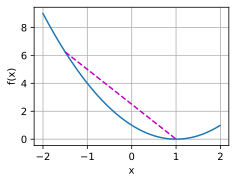

In [7]:
x, segment = torch.arange(-2, 2, 0.01), torch.tensor([-1.5, 1])
f = lambda x: (x - 1) ** 2
d2l.set_figsize()
d2l.plot([x, segment], [f(x), f(segment)], 'x', 'f(x)')

- 凸函数的下水平集是凸的

给定一个定义在凸集$\mathcal{X}$上的凸函数$f$，其任意一个下水平集

$$\mathcal{S}_b := \{x | x \in \mathcal{X} \text{ and } f(x) \leq b\}$$

是凸的

- 凸性和二阶导数

当一个函数的二阶导数$f: \mathbb{R}^n \rightarrow \mathbb{R}$存在时，我们很容易检查这个函数的凸性。
我们需要做的就是检查$\nabla^2f \succeq 0$，
即对于所有$\mathbf{x} \in \mathbb{R}^n$，$\mathbf{x}^\top \mathbf{H} \mathbf{x} \geq 0$.
例如，函数$f(\mathbf{x}) = \frac{1}{2} \|\mathbf{x}\|^2$是凸的，因为$\nabla^2 f = \mathbf{1}$，即其导数是单位矩阵。

更正式地讲，$f$为凸函数，当且仅当任意二次可微一维函数$f: \mathbb{R}^n \rightarrow \mathbb{R}$是凸的。
对于任意二次可微多维函数$f: \mathbb{R}^{n} \rightarrow \mathbb{R}$，
它是凸的当且仅当它的Hessian$\nabla^2f\succeq 0$。


### 2.3 约束

凸优化的一个很好的特性是能够让我们有效地处理*约束*（constraints）。
即它使我们能够解决以下形式的*约束优化*（constrained optimization）问题：

$$\begin{aligned} \mathop{\mathrm{minimize~}}_{\mathbf{x}} & f(\mathbf{x}) \\
    \text{ subject to } & c_i(\mathbf{x}) \leq 0 \text{ for all } i \in \{1, \ldots, N\}.
\end{aligned}$$

这里$f$是目标函数，$c_i$是约束函数。

- 拉格朗日函数
  
上述推理可以通过以下鞍点优化问题来表示：

$$L(\mathbf{x}, \alpha_1, \ldots, \alpha_n) = f(\mathbf{x}) + \sum_{i=1}^n \alpha_i c_i(\mathbf{x}) \text{ where } \alpha_i \geq 0.$$

这里的变量$\alpha_i$（$i=1,\ldots,n$）是所谓的*拉格朗日乘数*（Lagrange multipliers），它确保约束被正确地执行。
选择它们的大小足以确保所有$i$的$c_i(\mathbf{x}) \leq 0$。

- 惩罚

一种至少近似地满足约束优化问题的方法是采用拉格朗日函数$L$。通常，添加惩罚是确保近似满足约束的一种好方法。

- 投影

满足约束条件的另一种策略是*投影*（projections）。投影映射到凸集中最接近原始点的点。

## 3 梯度下降

* 学习率的大小很重要：学习率太大会使模型发散，学习率太小会没有进展。
* 梯度下降会可能陷入局部极小值，而得不到全局最小值。
* 在高维模型中，调整学习率是很复杂的。
* 预处理有助于调节比例。
* 牛顿法在凸问题中一旦开始正常工作，速度就会快得多。
* 对于非凸问题，不要不作任何调整就使用牛顿法。

### 3.1 一维梯度下降

epoch 10, x: 0.060466
results:  [10.0, 6.0, 3.5999999999999996, 2.1599999999999997, 1.2959999999999998, 0.7775999999999998, 0.46655999999999986, 0.2799359999999999, 0.16796159999999993, 0.10077695999999996, 0.06046617599999997]


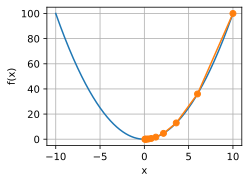

In [8]:
%matplotlib inline
import numpy as np
import torch
from d2l import torch as d2l

def f(x):  # 目标函数
    return x ** 2

def f_grad(x):  # 目标函数的梯度(导数)
    return 2 * x

def gd(eta, f_grad):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x)
        results.append(float(x))
    print(f'epoch 10, x: {x:f}')
    return results

results = gd(0.2, f_grad)
print("results: ", results)

def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    d2l.set_figsize()
    d2l.plot([f_line, results], [[f(x) for x in f_line], [
        f(x) for x in results]], 'x', 'f(x)', fmts=['-', '-o'])

show_trace(results, f)

### 3.2 学习率

epoch 10, x: 3.486784


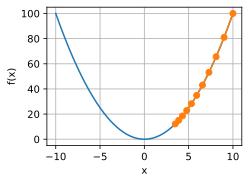

In [9]:
show_trace(gd(0.05, f_grad), f)

epoch 10, x: 61.917364


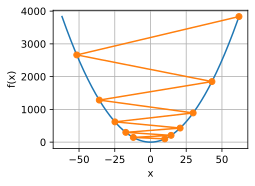

In [10]:
show_trace(gd(1.1, f_grad), f)

### 3.3 局部最小值

epoch 10, x: -1.528165


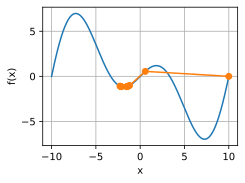

In [11]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # 目标函数
    return x * torch.cos(c * x)

def f_grad(x):  # 目标函数的梯度
    return torch.cos(c * x) - c * x * torch.sin(c * x)

show_trace(gd(2, f_grad), f)

### 3.4 多元梯度下降

epoch 20, x1: -0.057646, x2: -0.000073


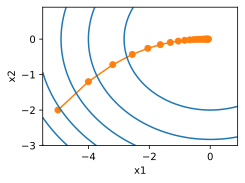

In [12]:
def train_2d(trainer, steps=20, f_grad=None):  #@save
    """用定制的训练机优化2D目标函数"""
    # s1和s2是稍后将使用的内部状态变量
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

def show_trace_2d(f, results):  #@save
    """显示优化过程中2D变量的轨迹"""
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1),
                          torch.arange(-3.0, 1.0, 0.1), indexing='ij')
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

def f_2d(x1, x2):  # 目标函数
    return x1 ** 2 + 2 * x2 ** 2

def f_2d_grad(x1, x2):  # 目标函数的梯度
    return (2 * x1, 4 * x2)

def gd_2d(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)

eta = 0.1
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))

### 3.5 自适应方法

- 牛顿法

函数$f: \mathbb{R}^d \rightarrow \mathbb{R}$的泰勒展开式，可以写成

$$f(\mathbf{x} + \boldsymbol{\epsilon}) = f(\mathbf{x}) + \boldsymbol{\epsilon}^\top \nabla f(\mathbf{x}) + \frac{1}{2} \boldsymbol{\epsilon}^\top \nabla^2 f(\mathbf{x}) \boldsymbol{\epsilon} + \mathcal{O}(\|\boldsymbol{\epsilon}\|^3).$$

将$\mathbf{H} \stackrel{\mathrm{def}}{=} \nabla^2 f(\mathbf{x})$定义为$f$的Hessian。在牛顿法中，最终将除以Hessian

epoch 10, x: tensor(0.)


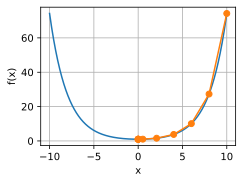

In [13]:
c = torch.tensor(0.5)

def f(x):  # O目标函数
    return torch.cosh(c * x)

def f_grad(x):  # 目标函数的梯度
    return c * torch.sinh(c * x)

def f_hess(x):  # 目标函数的Hessian
    return c**2 * torch.cosh(c * x)

def newton(eta=1):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x) / f_hess(x)
        results.append(float(x))
    print('epoch 10, x:', x)
    return results

show_trace(newton(), f)

- 收敛性分析

- 预处理

计算和存储完整的Hessian非常昂贵，而改善这个问题的一种方法是“预处理”。
它回避了计算整个Hessian，而只计算“对角线”项，即如下的算法更新：

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \mathrm{diag}(\mathbf{H})^{-1} \nabla f(\mathbf{x}).$$

- 梯度下降和线搜索

梯度下降的一个关键问题是我们可能会超过目标或进展不足，
解决这一问题的简单方法是结合使用线搜索和梯度下降。
也就是说，我们使用$\nabla f(\mathbf{x})$给出的方向，
然后进行二分搜索，以确定哪个学习率$\eta$使$f(\mathbf{x} - \eta \nabla f(\mathbf{x}))$取最小值。

## 4 随机梯度下降

* 对于凸问题，我们可以证明，对于广泛的学习率选择，随机梯度下降将收敛到最优解。
* 对于深度学习而言，情况通常并非如此。但是，对凸问题的分析使我们能够深入了解如何进行优化，即逐步降低学习率，尽管不是太快。
* 如果学习率太小或太大，就会出现问题。实际上，通常只有经过多次实验后才能找到合适的学习率。
* 当训练数据集中有更多样本时，计算梯度下降的每次迭代的代价更高，因此在这些情况下，首选随机梯度下降。
* 随机梯度下降的最优性保证在非凸情况下一般不可用，因为需要检查的局部最小值的数量可能是指数级的。

### 4.1 随机梯度更新

epoch 50, x1: 0.248362, x2: -0.165118


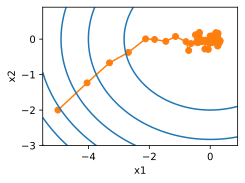

In [14]:
%matplotlib inline
import math
import torch
from d2l import torch as d2l

def f(x1, x2):  # 目标函数
    return x1 ** 2 + 2 * x2 ** 2

def f_grad(x1, x2):  # 目标函数的梯度
    return 2 * x1, 4 * x2

def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    # 模拟有噪声的梯度
    g1 += torch.normal(0.0, 1, (1,)).item()
    g2 += torch.normal(0.0, 1, (1,)).item()
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

def constant_lr():
    return 1

eta = 0.1
lr = constant_lr  # 常数学习速度
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

### 4.2 动态学习率

用与时间相关的学习率$\eta(t)$取代$\eta$增加了控制优化算法收敛的复杂性。特别是，我们需要弄清$\eta$的衰减速度。如果太快，我们将过早停止优化。如果减少的太慢，我们会在优化上浪费太多时间。以下是随着时间推移调整$\eta$时使用的一些基本策略（稍后我们将讨论更高级的策略）：

$$
\begin{aligned}
    \eta(t) & = \eta_i \text{ if } t_i \leq t \leq t_{i+1}  && \text{分段常数} \\
    \eta(t) & = \eta_0 \cdot e^{-\lambda t} && \text{指数衰减} \\
    \eta(t) & = \eta_0 \cdot (\beta t + 1)^{-\alpha} && \text{多项式衰减}
\end{aligned}
$$


epoch 1000, x1: -0.847498, x2: -0.049654


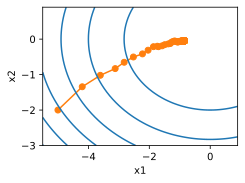

In [15]:
# 指数衰减
def exponential_lr():
    # 在函数外部定义，而在内部更新的全局变量
    global t
    t += 1
    return math.exp(-0.1 * t)

t = 1
lr = exponential_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=1000, f_grad=f_grad))

epoch 50, x1: 0.008402, x2: -0.000048


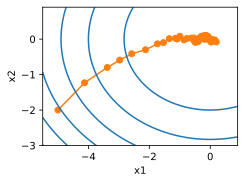

In [16]:
# 多项式衰减
def polynomial_lr():
    # 在函数外部定义，而在内部更新的全局变量
    global t
    t += 1
    return (1 + 0.1 * t) ** (-0.5)

t = 1
lr = polynomial_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

## 5 小批量随机梯度下降

* 由于减少了深度学习框架的额外开销，使用更好的内存定位以及CPU和GPU上的缓存，向量化使代码更加高效。
* 随机梯度下降的“统计效率”与大批量一次处理数据的“计算效率”之间存在权衡。小批量随机梯度下降提供了两全其美的答案：计算和统计效率。
* 在小批量随机梯度下降中，我们处理通过训练数据的随机排列获得的批量数据（即每个观测值只处理一次，但按随机顺序）。
* 在训练期间降低学习率有助于训练。
* 一般来说，小批量随机梯度下降比随机梯度下降和梯度下降的速度快，收敛风险较小。

### 5.1 向量化和缓存


In [22]:
%matplotlib inline
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

timer = d2l.Timer()
A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)

# 逐元素计算A=BC
timer.start()
for i in range(256):
    for j in range(256):
        A[i, j] = torch.dot(B[i, :], C[:, j])
timer.stop()

# 逐列计算A=BC
timer.start()
for j in range(256):
    A[:, j] = torch.mv(B, C[:, j])
timer.stop()

# 一次性计算A=BC
timer.start()
A = torch.mm(B, C)
timer.stop()

# 乘法和加法作为单独的操作（在实践中融合）
gigaflops = [2/i for i in timer.times]
print(timer.times)
print(f'performance in Gigaflops: element {gigaflops[0]:.3f}, '
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')

[0.554387092590332, 0.0028879642486572266, 0.00017213821411132812]
performance in Gigaflops: element 3.608, column 692.529, full 11618.571


### 5.2 小批量

小批量上的计算基本上与完整矩阵一样有效，提高计算效率。

In [23]:
timer.start()
for j in range(0, 256, 64):
    A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
timer.stop()
print(f'performance in Gigaflops: block {2 / timer.times[3]:.3f}')

performance in Gigaflops: block 662.450


### 5.3 从零实现

In [26]:
# 读取数据集
#@save
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

#@save
def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1

def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

#@save
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # 初始化模型
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # 训练模型
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(
        sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

loss: 0.251, 0.014 sec/epoch


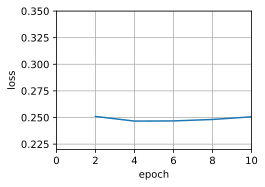

In [27]:
# 先将小批量设为1500（即样本总数），批量梯度下降
gd_res = train_sgd(1, 1500, 10)

loss: 0.245, 0.023 sec/epoch


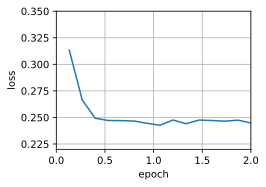

In [28]:
# 当批量大小为1时，优化使用的是随机梯度下降
sgd_res = train_sgd(0.005, 1)

loss: 0.245, 0.002 sec/epoch


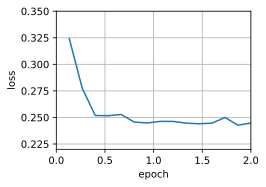

In [29]:
# 当批量大小等于100时，我们使用小批量随机梯度下降进行优化。
# 每个迭代轮数所需的时间比随机梯度下降和批量梯度下降所需的时间短。
mini1_res = train_sgd(.4, 100)

loss: 0.243, 0.004 sec/epoch


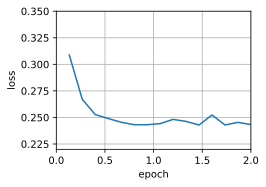

In [30]:
# 将批量大小减少到10，每个迭代轮数的时间都会增加，因为每批工作负载的执行效率变得更低。
mini2_res = train_sgd(.05, 10)

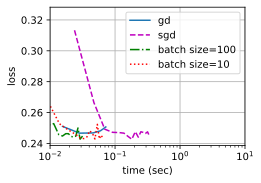

In [31]:
d2l.set_figsize([6, 3])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
         'time (sec)', 'loss', xlim=[1e-2, 10],
         legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
d2l.plt.gca().set_xscale('log')

### 5.4 简洁实现

loss: 0.242, 0.006 sec/epoch


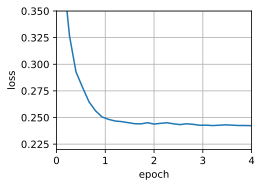

In [33]:
#@save
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # 初始化模型
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # MSELoss计算平方误差时不带系数1/2
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

## 6 动量法

* 动量法用过去梯度的平均值来替换梯度，这大大加快了收敛速度。
* 对于无噪声梯度下降和嘈杂随机梯度下降，动量法都是可取的。
* 动量法可以防止在随机梯度下降的优化过程停滞的问题。
* 由于对过去的数据进行了指数降权，有效梯度数为$\frac{1}{1-\beta}$。
* 在凸二次问题中，可以对动量法进行明确而详细的分析。
* 动量法的实现非常简单，但它需要我们存储额外的状态向量（动量$\mathbf{v}$）。

**算法**：

$$
\begin{aligned}
\mathbf{v}_t &\leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}, \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t.
\end{aligned}
$$

$$\mathbf{g}_{t, t-1} = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w}_{t-1}) = \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} \mathbf{h}_{i, t-1}.
$$

为了保持记法简单，在这里我们使用$\mathbf{h}_{i, t-1} = \partial_{\mathbf{w}} f(\mathbf{x}_i, \mathbf{w}_{t-1})$作为样本$i$的随机梯度下降，使用时间$t-1$时更新的权重$t-1$。

为了更详细地解释，让我们递归地将$\mathbf{v}_t$扩展到

$$\begin{aligned}
\mathbf{v}_t = \beta^2 \mathbf{v}_{t-2} + \beta \mathbf{g}_{t-1, t-2} + \mathbf{g}_{t, t-1}
= \ldots, = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}.
\end{aligned}$$

epoch 20, x1: 0.007188, x2: 0.002553


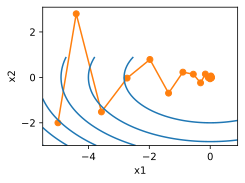

In [34]:
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

eta, beta = 0.6, 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

### 6.1 从零实现 

loss: 0.243, 0.006 sec/epoch


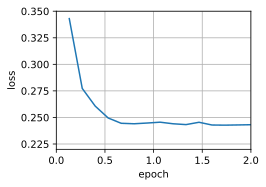

In [35]:
def init_momentum_states(feature_dim):
    v_w = torch.zeros((feature_dim, 1))
    v_b = torch.zeros(1)
    return (v_w, v_b)

def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = hyperparams['momentum'] * v + p.grad
            p[:] -= hyperparams['lr'] * v
        p.grad.data.zero_()

def train_momentum(lr, momentum, num_epochs=2):
    d2l.train_ch11(sgd_momentum, init_momentum_states(feature_dim),
                   {'lr': lr, 'momentum': momentum}, data_iter,
                   feature_dim, num_epochs)

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
train_momentum(0.02, 0.5)

loss: 0.246, 0.010 sec/epoch


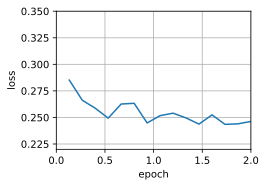

In [36]:
# 将动量超参数`momentum`增加到0.9时，它相当于有效样本数量增加到$\frac{1}{1 - 0.9} = 10$。将学习率略微降至$0.01$，以确保可控。
train_momentum(0.01, 0.9)

loss: 0.245, 0.006 sec/epoch


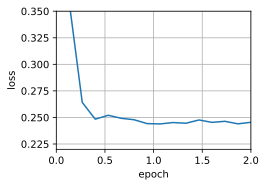

In [37]:
# 降低学习率进一步解决了任何非平滑优化问题的困难，将其设置为$0.005$会产生良好的收敛性能。
train_momentum(0.005, 0.9)

### 6.2 简洁实现

loss: 0.252, 0.005 sec/epoch


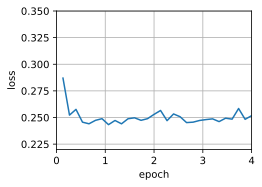

In [38]:
trainer = torch.optim.SGD
d2l.train_concise_ch11(trainer, {'lr': 0.005, 'momentum': 0.9}, data_iter)

## 7 AdaGrad算法

AdaGrad算法:通过将粗略的计数器$s(i, t)$替换为先前观察所得梯度的平方之和来解决这个问题。
它使用$s(i, t+1) = s(i, t) + \left(\partial_i f(\mathbf{x})\right)^2$来调整学习率。
这有两个好处：首先，我们不再需要决定梯度何时算足够大。
其次，它会随梯度的大小自动变化。通常对应于较大梯度的坐标会显著缩小，而其他梯度较小的坐标则会得到更平滑的处理。
在实际应用中，它促成了计算广告学及其相关问题中非常有效的优化程序。

* AdaGrad算法会在单个坐标层面动态降低学习率。
* AdaGrad算法利用梯度的大小作为调整进度速率的手段：用较小的学习率来补偿带有较大梯度的坐标。
* 在深度学习问题中，由于内存和计算限制，计算准确的二阶导数通常是不可行的。梯度可以作为一个有效的代理。
* 如果优化问题的结构相当不均匀，AdaGrad算法可以帮助缓解扭曲。
* AdaGrad算法对于稀疏特征特别有效，在此情况下由于不常出现的问题，学习率需要更慢地降低。
* 在深度学习问题上，AdaGrad算法有时在降低学习率方面可能过于剧烈。

**算法**：

使用变量$\mathbf{s}_t$来累加过去的梯度方差，如下所示：

$$\begin{aligned}
    \mathbf{g}_t & = \partial_{\mathbf{w}} l(y_t, f(\mathbf{x}_t, \mathbf{w})), \\
    \mathbf{s}_t & = \mathbf{s}_{t-1} + \mathbf{g}_t^2, \\
    \mathbf{w}_t & = \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \cdot \mathbf{g}_t.
\end{aligned}$$

epoch 20, x1: -2.382563, x2: -0.158591


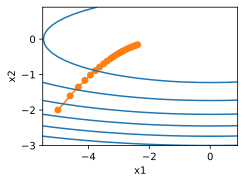

In [39]:
# 示例
%matplotlib inline
import math
import torch
from d2l import torch as d2l

def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

epoch 20, x1: -0.002295, x2: -0.000000


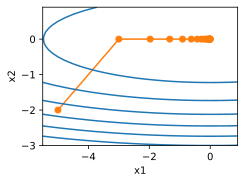

In [40]:
# 我们将学习率提高到$2$，可以看到更好的表现
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

### 7.1 从零实现

loss: 0.244, 0.005 sec/epoch


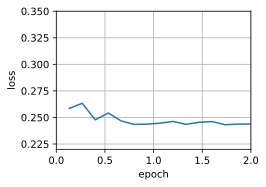

In [41]:
def init_adagrad_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] += torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adagrad, init_adagrad_states(feature_dim),
               {'lr': 0.1}, data_iter, feature_dim);

### 7.2 简洁实现

loss: 0.243, 0.006 sec/epoch


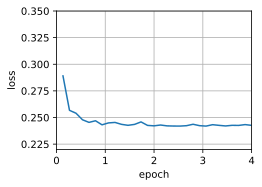

In [42]:
trainer = torch.optim.Adagrad
d2l.train_concise_ch11(trainer, {'lr': 0.1}, data_iter)

## 8 RMSProp算法

* RMSProp算法与Adagrad算法非常相似，因为两者都使用梯度的平方来缩放系数。
* RMSProp算法与动量法都使用泄漏平均值。但是，RMSProp算法使用该技术来调整按系数顺序的预处理器。
* 在实验中，学习率需要由实验者调度。
* 系数$\gamma$决定了在调整每坐标比例时历史记录的时长。

**算法**：

$$\begin{aligned}
    \mathbf{s}_t & \leftarrow \gamma \mathbf{s}_{t-1} + (1 - \gamma) \mathbf{g}_t^2, \\
    \mathbf{x}_t & \leftarrow \mathbf{x}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t.
\end{aligned}$$

常数$\epsilon > 0$通常设置为$10^{-6}$，以确保我们不会因除以零或步长过大而受到影响。
鉴于这种扩展，我们现在可以自由控制学习率$\eta$，而不考虑基于每个坐标应用的缩放。
就泄漏平均值而言，我们可以采用与之前在动量法中适用的相同推理。
扩展$\mathbf{s}_t$定义可获得

$$
\begin{aligned}
\mathbf{s}_t & = (1 - \gamma) \mathbf{g}_t^2 + \gamma \mathbf{s}_{t-1} \\
& = (1 - \gamma) \left(\mathbf{g}_t^2 + \gamma \mathbf{g}_{t-1}^2 + \gamma^2 \mathbf{g}_{t-2} + \ldots, \right).
\end{aligned}
$$

示例：$f(\mathbf{x})=0.1x_1^2+2x_2^2$

epoch 20, x1: -0.010599, x2: 0.000000


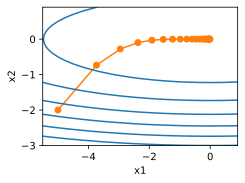

In [43]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

### 8.1 从零实现

loss: 0.246, 0.006 sec/epoch


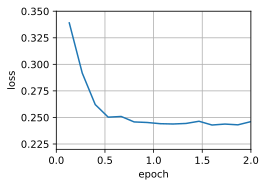

In [44]:
def init_rmsprop_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

# 将初始学习率设置为0.01，加权项$\gamma$设置为0.9。也就是说，$\mathbf{s}$累加了过去的$1/(1-\gamma) = 10$次平方梯度观测值的平均值。
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(rmsprop, init_rmsprop_states(feature_dim),
               {'lr': 0.01, 'gamma': 0.9}, data_iter, feature_dim);

### 8.2 简洁实现

loss: 0.243, 0.006 sec/epoch


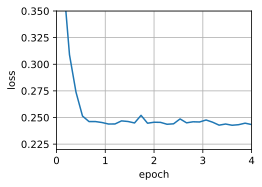

In [45]:
trainer = torch.optim.RMSprop
d2l.train_concise_ch11(trainer, {'lr': 0.01, 'alpha': 0.9},
                       data_iter)

## 9 Adadelta算法

* Adadelta是AdaGrad的另一种变体，主要区别在于前者减少了学习率适应坐标的数量。
* Adadelta没有学习率参数。相反，它使用参数本身的变化率来调整学习率。
* Adadelta需要两个状态变量来存储梯度的二阶导数和参数的变化。
* Adadelta使用泄漏的平均值来保持对适当统计数据的运行估计。

**算法**：

Adadelta使用两个状态变量，$\mathbf{s}_t$用于存储梯度二阶导数的泄露平均值，$\Delta\mathbf{x}_t$用于存储模型本身中参数变化二阶导数的泄露平均值。

$$\begin{aligned}
    \mathbf{s}_t & = \rho \mathbf{s}_{t-1} + (1 - \rho) \mathbf{g}_t^2.
\end{aligned}$$

与 :numref:`sec_rmsprop`的区别在于，我们使用重新缩放的梯度$\mathbf{g}_t'$执行更新，即

$$\begin{aligned}
    \mathbf{x}_t  & = \mathbf{x}_{t-1} - \mathbf{g}_t'. \\
\end{aligned}$$

那么，调整后的梯度$\mathbf{g}_t'$是什么？我们可以按如下方式计算它：

$$\begin{aligned}
    \mathbf{g}_t' & = \frac{\sqrt{\Delta\mathbf{x}_{t-1} + \epsilon}}{\sqrt{{\mathbf{s}_t + \epsilon}}} \odot \mathbf{g}_t, \\
\end{aligned}$$

其中$\Delta \mathbf{x}_{t-1}$是重新缩放梯度的平方$\mathbf{g}_t'$的泄漏平均值。我们将$\Delta \mathbf{x}_{0}$初始化为$0$，然后在每个步骤中使用$\mathbf{g}_t'$更新它，即

$$\begin{aligned}
    \Delta \mathbf{x}_t & = \rho \Delta\mathbf{x}_{t-1} + (1 - \rho) {\mathbf{g}_t'}^2,
\end{aligned}$$

和$\epsilon$（例如$10^{-5}$这样的小值）是为了保持数字稳定性而加入的。


### 9.1 从零实现

loss: 0.245, 0.008 sec/epoch


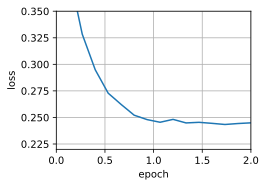

In [46]:
%matplotlib inline
import torch
from d2l import torch as d2l


def init_adadelta_states(feature_dim):
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    delta_w, delta_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        with torch.no_grad():
            # In-placeupdatesvia[:]
            s[:] = rho * s + (1 - rho) * torch.square(p.grad)
            g = (torch.sqrt(delta + eps) / torch.sqrt(s + eps)) * p.grad
            p[:] -= g
            delta[:] = rho * delta + (1 - rho) * g * g
        p.grad.data.zero_()

# 选择rho = 0.9相当于10个半衰期
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adadelta, init_adadelta_states(feature_dim),
               {'rho': 0.9}, data_iter, feature_dim);

### 9.2 简洁实现

loss: 0.243, 0.006 sec/epoch


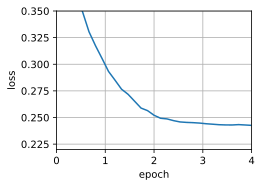

In [47]:
trainer = torch.optim.Adadelta
d2l.train_concise_ch11(trainer, {'rho': 0.9}, data_iter)

## 10 Adam算法

* Adam算法将许多优化算法的功能结合到了相当强大的更新规则中。
* Adam算法在RMSProp算法基础上创建的，还在小批量的随机梯度上使用EWMA。
* 在估计动量和二次矩时，Adam算法使用偏差校正来调整缓慢的启动速度。
* 对于具有显著差异的梯度，我们可能会遇到收敛性问题。我们可以通过使用更大的小批量或者切换到改进的估计值$\mathbf{s}_t$来修正它们。Yogi提供了这样的替代方案。


**算法**：

Adam算法的关键组成部分之一是：它使用指数加权移动平均值来估算梯度的动量和二次矩，即它使用状态变量

$$\begin{aligned}
    \mathbf{v}_t & \leftarrow \beta_1 \mathbf{v}_{t-1} + (1 - \beta_1) \mathbf{g}_t, \\
    \mathbf{s}_t & \leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2.
\end{aligned}$$

这里$\beta_1$和$\beta_2$是非负加权参数。
常将它们设置为$\beta_1 = 0.9$和$\beta_2 = 0.999$。
也就是说，方差估计的移动远远慢于动量估计的移动。
注意，如果我们初始化$\mathbf{v}_0 = \mathbf{s}_0 = 0$，就会获得一个相当大的初始偏差。
我们可以通过使用$\sum_{i=0}^t \beta^i = \frac{1 - \beta^t}{1 - \beta}$来解决这个问题。
相应地，标准化状态变量由下式获得

$$\hat{\mathbf{v}}_t = \frac{\mathbf{v}_t}{1 - \beta_1^t} \text{ and } \hat{\mathbf{s}}_t = \frac{\mathbf{s}_t}{1 - \beta_2^t}.$$

有了正确的估计，我们现在可以写出更新方程。
首先，我们以非常类似于RMSProp算法的方式重新缩放梯度以获得

$$\mathbf{g}_t' = \frac{\eta \hat{\mathbf{v}}_t}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}.$$

与RMSProp不同，我们的更新使用动量$\hat{\mathbf{v}}_t$而不是梯度本身。
此外，由于使用$\frac{1}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}$而不是$\frac{1}{\sqrt{\hat{\mathbf{s}}_t + \epsilon}}$进行缩放，两者会略有差异。
前者在实践中效果略好一些，因此与RMSProp算法有所区分。
通常，我们选择$\epsilon = 10^{-6}$，这是为了在数值稳定性和逼真度之间取得良好的平衡。

最后，我们简单更新：

$$\mathbf{x}_t \leftarrow \mathbf{x}_{t-1} - \mathbf{g}_t'.$$

回顾Adam算法，它的设计灵感很清楚：
首先，动量和规模在状态变量中清晰可见，
它们相当独特的定义使我们移除偏项（这可以通过稍微不同的初始化和更新条件来修正）。
其次，RMSProp算法中两项的组合都非常简单。
最后，明确的学习率$\eta$使我们能够控制步长来解决收敛问题。

### 10.1 从零实现

loss: 0.244, 0.008 sec/epoch


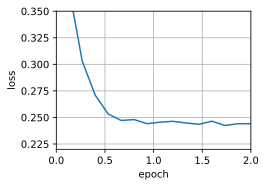

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l


def init_adam_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adam, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

### 10.2 简洁实现

loss: 0.242, 0.006 sec/epoch


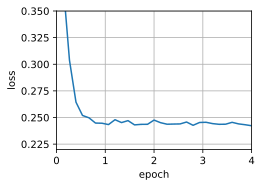

In [2]:
trainer = torch.optim.Adam
d2l.train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

### 10.3 Yogi


loss: 0.244, 0.006 sec/epoch


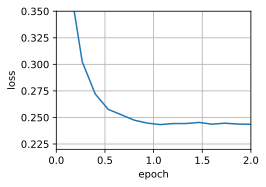

In [3]:
def yogi(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-3
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = s + (1 - beta2) * torch.sign(
                torch.square(p.grad) - s) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(yogi, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

## 11 学习率调度器

* 调整学习率和更新权重向量的优化算法同样重要，可以考虑学习率大小、衰减率、初始化、周期调整
* 在训练期间逐步降低学习率可以提高准确性，并且减少模型的过拟合。
* 在实验中，每当进展趋于稳定时就降低学习率，这是很有效的。从本质上说，这可以确保我们有效地收敛到一个适当的解，也只有这样才能通过降低学习率来减小参数的固有方差。
* 余弦调度器在某些计算机视觉问题中很受欢迎。
* 优化之前的预热期可以防止发散。
* 优化在深度学习中有多种用途。对于同样的训练误差而言，选择不同的优化算法和学习率调度，除了最大限度地减少训练时间，可以导致测试集上不同的泛化和过拟合量。

### 11.1 学习率调度器

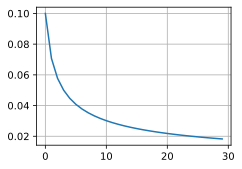

In [9]:
from torch import nn
from torch.optim import lr_scheduler
import math

class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)
    
scheduler = SquareRootScheduler(lr=0.1)
num_epochs = 30
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])


### 11.2 策略

- 单因子调度器

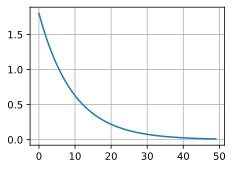

In [5]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
d2l.plot(torch.arange(50), [scheduler(t) for t in range(50)])

- 多因子调度器

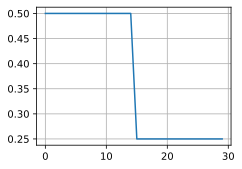

In [7]:
def net_fn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10))

    return model

net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[15, 30], gamma=0.5)

def get_lr(trainer, scheduler):
    lr = scheduler.get_last_lr()[0]
    trainer.step()
    scheduler.step()
    return lr

d2l.plot(torch.arange(num_epochs), [get_lr(trainer, scheduler)
                                  for t in range(num_epochs)])

- 余弦调度器

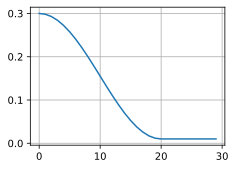

In [10]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

- 预热

一个解决初始化参数的方法是使用预热期，在此期间学习率将增加至初始最大值，然后冷却直到优化过程结束。为了简单起见，通常使用线性递增。

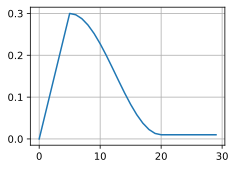

In [11]:
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])